In [1]:
import pytimber as pt
import matplotlib.pyplot as plt
from nxcals.spark_session_builder import get_or_create
from nxcals.api.extraction.data.builders import DataQuery
from datetime import datetime, timezone, timedelta

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

import numpy as np
import scipy.optimize as opt
import scipy.optimize as opt
from scipy.special import erf
from scipy.stats import norm

In [2]:
spark = get_or_create("My_APP")


ENVIRONMENT:
NXCALS_VERSION=1.5.8
VIRTUAL_ENV=
SPARK_HOME=/home/cmaccani/anaconda3/nxcals-bundle
SPARK_CONF_DIR=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/conf
SPARK_DEFAULTS=/home/cmaccani/anaconda3/nxcals-bundle/conf/spark-defaults.conf
NXCALS_WORKSPACE_TEMP_DIR=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6
PACKED_VENV_FILE=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/nxcals-python3-env.tar.gz
PYSPARK_PYTHON=/home/cmaccani/anaconda3/bin/python
PYSPARK_DRIVER_PYTHON=/bin/python
PYSPARK_DRIVER_PYTHON_OPTS=
LOCK=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/.lock

IMPORTANT:
Rebuilding of the packed venv is required in cases there are new or modified packages provided by a user. In order to recreate the packed venv please:
        - remove the file (rm /tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/nxcals-python3-env.tar.gz)
        - execute your script again (rebuild will be performed during the startup of PySpark/Python)
Target directory can

24/05/14 15:23:04 WARN Utils: Service 'sparkDriver' could not bind on port 5001. Attempting port 5002.
24/05/14 15:23:04 WARN Utils: Service 'SparkUI' could not bind on port 5201. Attempting port 5202.
24/05/14 15:23:05 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 5101. Attempting port 5102.


In [3]:
lbd = pt.LoggingDB(source='nxcals', spark_session=spark)

In [4]:
config = 'B1V'
scan = '1'

if (config == 'B1V'):
	sigma1 = 4.86
	blm_metadata = 'BLMTI.04L7.B1E10_TCSG.D4L7.B1:LOSS_RS09'
	cry_metadata = 'BLMTI.06L7.B1E10_TCPCV.A6L7.B1:LOSS_RS09'
	lin_metadata = 'TCSG.D4L7.B1:MEAS_MOTOR_LU'
	int_metadata = 'LHC.BCTFR.A6R4.B1:BEAM_INTENSITY'
	alpha1 = -2.423802937
	beta1 = 255.7212085
	phi1 = 44.21375511
	alpha2 = 0.9016580719
	beta2 = 68.87110987
	phi2 = 44.28227085
#	center2 = -0.09
	center2 = 0
	param0 = [0.0,1,-3.5,0.01]
	meanlim = 1.5
	scan = '1' #raw_input('Which scan? (1-2): ')
	if (scan == '1'):
		tMin_bkg = '2022-06-03 05:11:30.000'
		tMax_bkg = '2022-06-03 05:11:50.000'
		tMin = '2022-06-03 05:12:05.000'
		tMax = '2022-06-03 05:20:58.000'
		norm_l1 = -0.795
		norm_l2 = -0.795
#		norm_l2 = -0.865
		maxfit = -1.5
	if (scan == '2'):
		tMin_bkg = '2022-06-03 05:35:15.000'
		tMax_bkg = '2022-06-03 05:35:45.000'
		tMin = '2022-06-03 05:38:10.000'
		tMax = '2022-06-03 05:45:54.000'
		norm_l1 = -0.865
		norm_l2 = -0.865
#		norm_l2 = -0.845
		maxfit = -1.5

In [10]:
Bkg_data = lbd.get(blm_metadata, tMin_bkg , tMax_bkg )
DeltaBLM_bkg = Bkg_data[blm_metadata][0]
BLM_bkg =  Bkg_data[blm_metadata][1]

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


In [12]:

def datestring_to_timestamp_utc(date_string):
    # Parse the date string into a datetime object
    date_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S.%f') - timedelta(hours=2)
    
    # Convert the datetime object to UTC timezone if it's not already in UTC
    if date_obj.tzinfo is None or date_obj.tzinfo.utcoffset(date_obj) is None:
        date_obj = date_obj.replace(tzinfo=timezone.utc)
    else:
        date_obj = date_obj.astimezone(timezone.utc)
    
    # Extract the timestamp in seconds
    timestamp_utc = date_obj.timestamp()
    
    return timestamp_utc

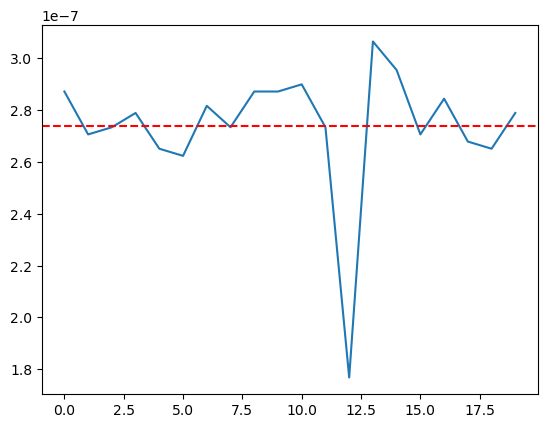

In [13]:
#BLM_bkg = signal[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin_bkg)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax_bkg)))[0][0]]
#time_bkg = time[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin_bkg)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax_bkg)))[0][0]]
DeltaBLM_bkg = np.array([i - DeltaBLM_bkg[0] for i in DeltaBLM_bkg])
bkg_mean = np.mean(BLM_bkg)

fig, ax = plt.subplots()
ax.plot(DeltaBLM_bkg, BLM_bkg)
ax.axhline(y=bkg_mean, color='r', linestyle='--')

In [16]:
Scan_data = lbd.get(blm_metadata, tMin, tMax)
DeltaBLM = Scan_data[blm_metadata][0]
SignalBLM =  Scan_data[blm_metadata][1]

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


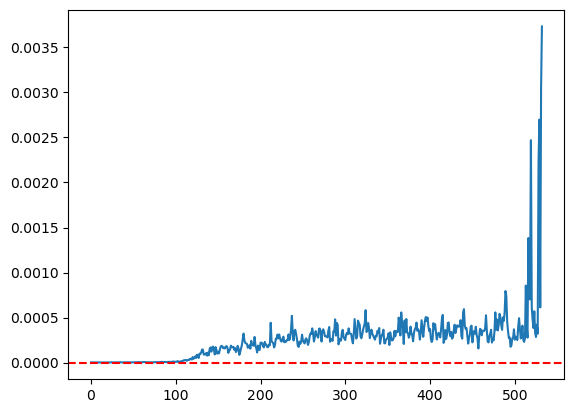

In [18]:
#BLM_scan = signal[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax)-1))[0][0]]
#time_scan = time[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax)-1))[0][0]]
DeltaBLM = np.array([i - DeltaBLM[0] for i in DeltaBLM])
SignalBLM = SignalBLM - bkg_mean

fig, ax = plt.subplots()
ax.plot(DeltaBLM, SignalBLM)
ax.axhline(y=0, color='r', linestyle='--')

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


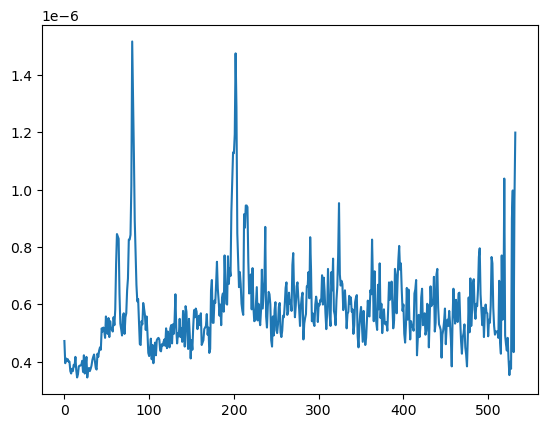

In [19]:
SignalCRY = lbd.get(cry_metadata, tMin, tMax )[cry_metadata][1]

plt.plot(DeltaBLM, SignalCRY)

In [20]:
lin_metadata = 'TCSG.D4L7.B1:MEAS_MOTOR_LU'
CollPos = lbd.get(lin_metadata, tMin , tMax )[lin_metadata][1]

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


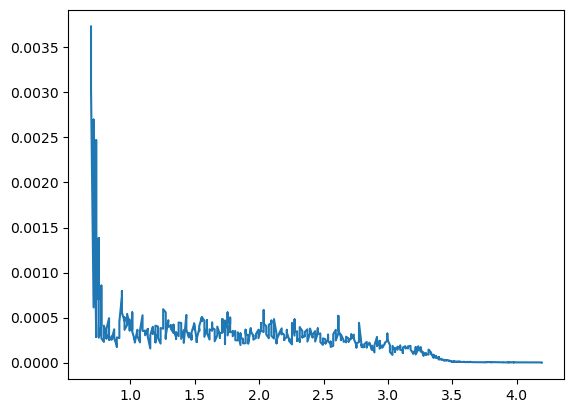

In [23]:
fig, ax = plt.subplots()
ax.plot(CollPos, SignalBLM)
#ax.set_ylim(0, 0.00004)

In [21]:
int_metadata = 'LHC.BCTFR.A6R4.B1:BEAM_INTENSITY'
BeamInt = lbd.get(int_metadata, tMin, tMax )[int_metadata][1]

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


In [25]:
MeanCollPos = []
SignalBLMRedu = []
SignalBLMErr = []
SignalCRYRedu = []
BeamIntRedu = []
DeltaBLMRedu = []

i = 1

while i < len(CollPos):
    count = 1
    SumPos = CollPos[i-1]
    BLMmean = []
    CRYmean = []
    Intmean = []
    DeltaBLMmean = []
    BLMmean.append(SignalBLM[i-1])
    CRYmean.append(SignalCRY[i-1])
    Intmean.append(BeamInt[i-1])
    DeltaBLMmean.append(DeltaBLM[i-1])

    # if the absorber stays in the same position for more than one measurement, compoute the mean of the signals
    while CollPos[i] == CollPos[i-1]:
        
        count += 1
        SumPos += CollPos[i]
        BLMmean.append(SignalBLM[i])
        CRYmean.append(SignalCRY[i])
        Intmean.append(BeamInt[i])
        DeltaBLMmean.append(DeltaBLM[i])
        i = i+1
        if i == len(CollPos):
            break
        
    MeanCollPos.append(round(SumPos/count,3))
    SignalBLMRedu.append(sum(BLMmean)/count)
    SignalBLMErr.append((max(BLMmean)-min(BLMmean))/2.)
    SignalCRYRedu.append(sum(CRYmean)/count)
    BeamIntRedu.append(sum(Intmean)/count)
    DeltaBLMRedu.append(round(sum(DeltaBLMmean)/count,3))
    i = i+1

In [40]:
for i in range(len(CollPos)):
    print(CollPos[i], DeltaBLM[i], SignalBLM[i])

4.195 0.0 1.8279243469238283e-06
4.195 1.0 2.2090583801269533e-06
4.175 2.0 2.2173439025878906e-06
4.175 3.0 1.4937416076660157e-06
4.175 4.0 1.6207862854003903e-06
4.155 5.0 1.9024940490722658e-06
4.155 6.0 1.872113800048828e-06
4.155 7.0 1.656690216064453e-06
4.135 8.0 2.3416267395019533e-06
4.135 9.0 1.9052558898925785e-06
4.135 10.0 1.640119171142578e-06
4.115 11.0 2.4023872375488285e-06
4.115 12.0 1.9549690246582033e-06
4.115 13.0 2.33886489868164e-06
4.095 14.0 2.557050323486328e-06
4.095 15.0 1.924588775634766e-06
4.095 16.0 1.7699256896972658e-06
4.075 17.0 2.0930610656738283e-06
4.075 18.0 2.7365699768066406e-06
4.075 19.0 2.2007728576660155e-06
4.055 20.0 2.4106727600097654e-06
4.055 21.0 3.2447486877441406e-06
4.055 22.0 3.1204658508300783e-06
4.035 23.0 2.8663764953613283e-06
4.035 24.0 2.181439971923828e-06
4.035 25.0 3.0624671936035154e-06
4.015 26.0 2.601239776611328e-06
4.015 27.0 1.6152626037597657e-06
4.015 28.0 2.2587715148925784e-06
3.995 29.0 2.548764801025391e-06


In [41]:
for i in range(len(MeanCollPos)):
    print(MeanCollPos[i], DeltaBLMRedu[i], SignalBLMRedu[i])

4.195 0.5 2.0184913635253908e-06
4.175 3.0 1.7772905985514321e-06
4.155 6.0 1.8104326883951822e-06
4.135 9.0 1.9623339335123702e-06
4.115 12.0 2.2320737202962237e-06
4.095 15.0 2.08385492960612e-06
4.075 18.0 2.343467966715495e-06
4.055 21.0 2.925295766194661e-06
4.035 24.0 2.7034278869628905e-06
4.015 27.0 2.1584246317545573e-06
3.995 30.0 2.3720069885253907e-06
3.975 33.0 3.0422136942545577e-06
3.955 36.0 3.0072303771972657e-06
3.935 39.0 2.89031244913737e-06
3.915 42.0 2.8792650858561203e-06
3.895 45.0 2.8599322001139325e-06
3.875 48.0 3.0744351704915362e-06
3.855 51.0 3.209765370686849e-06
3.835 54.0 3.81921157836914e-06
3.815 57.0 5.075849151611328e-06
3.795 60.0 4.35961176554362e-06
3.775 63.0 6.123507436116536e-06
3.755 66.0 3.550392405192057e-06
3.735 69.0 3.672834014892578e-06
3.715 72.0 3.5329007466634115e-06
3.695 75.0 4.3863095601399745e-06
3.675 78.0 4.471006011962891e-06
3.655 81.0 4.264788564046223e-06
3.635 84.0 7.074501291910807e-06
3.615 87.0 7.049644724527994e-06
3.5

(0.695, 0.855)

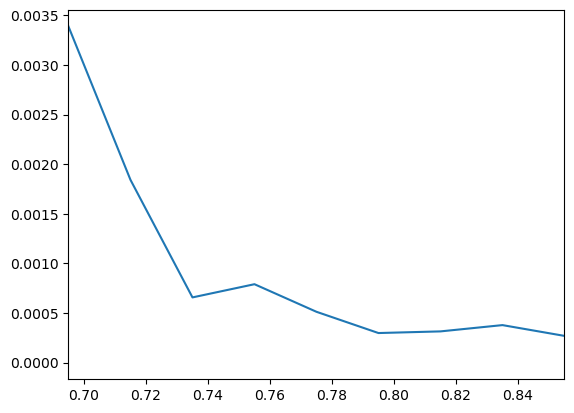

In [43]:
plt.plot(MeanCollPos, SignalBLMRedu)
plt.xlim(0.695, 0.855)

In [21]:
"""line_path = './input_files/2024_Run3/injection_b1.json'
coll_file = './input_files/colldbs/injection.yaml'

line = xt.Line.from_json(line_path)
#context = xo.ContextCpu() 
#coll_manager = xc.CollimatorManager.from_yaml(coll_file, line=line, beam=beam, _context=context, ignore_crystals=False)
#coll_names = coll_manager.collimator_names
#not_install = ['tccs.5r3.b2', 'tccp.4l3.b2', 'target.4l3.b2']
#everest_colls = [name for name in coll_names if name not in not_install]
#coll_manager.install_everest_collimators(names=everest_colls, verbose=False)
tw = line.twiss(method = '4d')

CRY_name = 'TCPCV.A6L7.B1'.lower()
COLL_name = 'TCSG.D4L7.B1'.lower()

deltaphi = float(tw[tw.name == COLL_name]['muy'])% 1* 2*np.pi - float(tw[tw.name == CRY_name]['muy'])% 1* 2*np.pi


beta1 = tw['bety',CRY_name]
beta2 = tw['bety',COLL_name]
alpha1 = tw['alphy',CRY_name]
alpha2 = tw['alphy',COLL_name]"""

"line_path = './input_files/2024_Run3/injection_b1.json'\ncoll_file = './input_files/colldbs/injection.yaml'\n\nline = xt.Line.from_json(line_path)\n#context = xo.ContextCpu() \n#coll_manager = xc.CollimatorManager.from_yaml(coll_file, line=line, beam=beam, _context=context, ignore_crystals=False)\n#coll_names = coll_manager.collimator_names\n#not_install = ['tccs.5r3.b2', 'tccp.4l3.b2', 'target.4l3.b2']\n#everest_colls = [name for name in coll_names if name not in not_install]\n#coll_manager.install_everest_collimators(names=everest_colls, verbose=False)\ntw = line.twiss(method = '4d')\n\nCRY_name = 'TCPCV.A6L7.B1'.lower()\nCOLL_name = 'TCSG.D4L7.B1'.lower()\n\ndeltaphi = float(tw[tw.name == COLL_name]['muy'])% 1* 2*np.pi - float(tw[tw.name == CRY_name]['muy'])% 1* 2*np.pi\n\n\nbeta1 = tw['bety',CRY_name]\nbeta2 = tw['bety',COLL_name]\nalpha1 = tw['alphy',CRY_name]\nalpha2 = tw['alphy',COLL_name]"

In [49]:
# manipulate data

energy = 6800  # 450   #GeV
mp = 0.9382    #GeV
emittance_n = 3.5e-6

beam = 1

gamma = energy/mp
beta = np.sqrt(1-1/gamma**2)
emittance = emittance_n/(beta*gamma)

beta_CRY = beta1 # 255.9338233009291 
beta_COLL = beta2 #69.78135304142256
alpha_CRY = alpha1 # -2.425125368857565
alpha_COLL = alpha2 #  0.9159815105221432

n_sigma_CRY = sigma1 #4.86

deltaphi_CRY_COLL = (phi2-phi1)*2*np.pi #0.4230901428863114 #deltaphi*(1+perc)
deltaphi = deltaphi_CRY_COLL

Theta = []
ActualPos = []

for step in range(len(MeanCollPos)):
	tActualPos = (MeanCollPos[step]-center2)
	tTheta = -((tActualPos*1e-3 - n_sigma_CRY*np.sqrt(emittance*beta_COLL)*np.cos(deltaphi_CRY_COLL))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL)))*1e6

	ActualPos.append(round(tActualPos,3))
	Theta.append(tTheta)
	

In [30]:
# write output file
import csv

iFilePlot = 'LinearScanPlot_'+config+'_'+scan+'.dat'
oBeamInt = 'BeamIntensityFit_'+config+'_'+scan+'.png'
oBLMNorm = 'BLMSignalNorm_'+config+'_'+scan+'.png'
oBLMFit = 'BLMSignalNormFit_'+config+'_'+scan+'_FT.png'
oScanNorm = 'LinearScanPlotNorm_'+config+'_'+scan+'.dat'

with open(iFilePlot,'w') as oFile:
	oFile.write('# DeltaBLM CollPos ActualPos Theta SignalBLM ErrBLM BeamInt SignalCry\n')
	writer = csv.writer(oFile,delimiter='\t')
	writer.writerows(zip(DeltaBLMRedu,MeanCollPos,ActualPos,Theta,SignalBLMRedu,SignalBLMErr,BeamIntRedu,SignalCRYRedu))

# Fit and Plot ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

with open(iFilePlot,'r') as readPlot:
	for line in readPlot:
		if line.split(' ')[0] != '#':
			t, collpos, actualpos, Ttheta, signalblm, errblm, beamint, signalcry = np.genfromtxt(readPlot, unpack=True)
			#DeltaBLMRedu,MeanCollPos,ActualPos,Theta,SignalBLMRedu,SignalBLMErr,BeamIntRedu,SignalCRYRedu


In [44]:
0.735 522.5 0.0006577402626037597

SyntaxError: invalid syntax (1914581785.py, line 1)

/tmp/cmaccani/ipykernel_54340/3202907120.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f0.show()


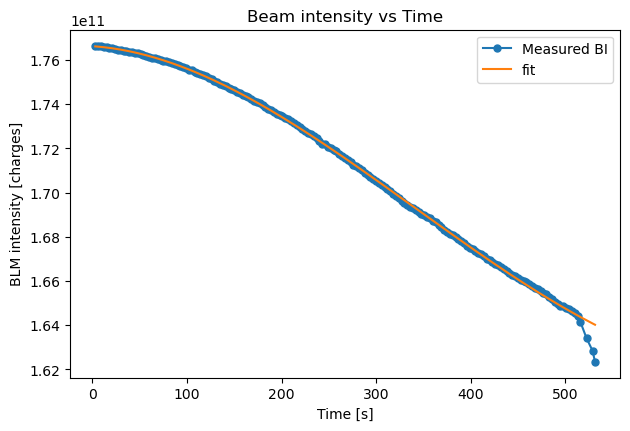

In [45]:
norm_l1 = 0.735
norm_l2 = 0.735

for i in range(len(t)):
	if actualpos[i] == norm_l1:
		t1 = t[i]
	if actualpos[i] == norm_l2:
		t2 = t[i]
t_lim = (t1+t2)/2.
t_fit = []
beamint_fit = []

for i in range(len(t)):
	if t[i] <= t_lim:
		t_fit.append(t[i])
		beamint_fit.append(beamint[i])

theta = [i for i in Ttheta]

f0 = plt.figure(0)
plt.title('Beam intensity vs Time')
plt.plot(t, beamint, label='Measured BI', marker='o', markersize=5)
p = np.polyfit(t_fit, beamint_fit, 3)
# p = np.polyfit(t_fit, beamint_fit, 5)
y = np.polyval(p, t)
plt.plot(t, y, label='fit')
plt.xlabel('Time [s]')
plt.ylabel('BLM intensity [charges]')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()

f0.show()
f0.tight_layout(rect=[0, 0.03, 1, 0.95])
#f0.savefig(oBeamInt)



/tmp/cmaccani/ipykernel_54340/1111496814.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f1.show()


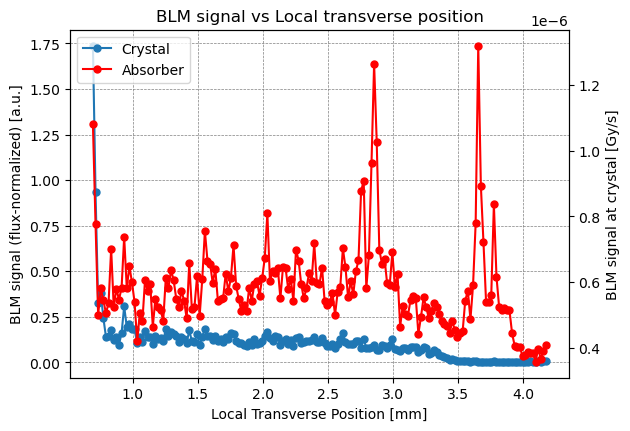

In [46]:
q = np.polyder(p)
signalblm_norm = []
errblm_norm = []


for i in range(len(t)):
	if actualpos[i] == norm_l1:
		norm_s1 = signalblm[i]/np.polyval(q,t[i])
	if actualpos[i] == norm_l2:
		norm_s2 = signalblm[i]/np.polyval(q,t[i])
normal = (norm_s1+norm_s2)/2.
norm_l = (norm_l1+norm_l2)/2.
# normal = normal*2.5/5
# print normal

count_norm = 0
mean_norm = []
for i in range(len(actualpos)):
	if actualpos[i] <= norm_l and actualpos[i] >= norm_l-meanlim:
		mean_norm.append(signalblm[i]/np.polyval(q,t[i]))
		count_norm += 1
normal = sum(mean_norm)/count_norm

for i in range(len(t)):
	signalblm_norm.append(signalblm[i]/abs(np.polyval(q,t[i])*normal))
	errblm_norm.append(errblm[i]/abs(np.polyval(q,t[i])*normal))

f1 = plt.figure(1)
ax3 = f1.add_subplot(111)
ax4 = ax3.twinx()
plt.title('BLM signal vs Local transverse position')
ax3.plot(actualpos, signalblm_norm, marker='o', markersize=5, label='Crystal')
ax4.plot(actualpos, signalcry, marker='o', markersize=5, color='red', label='Absorber')
ax3.set_xlabel('Local Transverse Position [mm]')
ax3.set_ylabel('BLM signal (flux-normalized) [a.u.]')
ax4.set_ylabel('BLM signal at crystal [Gy/s]')
ax3.grid(color='gray', linestyle='--', linewidth=0.5)
ax4.yaxis.grid(False)
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
plt.legend(lines3+lines4, labels3+labels4, fontsize=10, loc=2)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

f1.show()
f1.tight_layout(rect=[0, 0.03, 1, 0.95])
#f1.savefig(oBLMNorm)

In [108]:
actualpos

array([6.677, 6.578, 6.478, 6.377, 6.278, 6.177, 6.078, 5.978, 5.877,
       5.778, 5.677, 5.578, 5.478, 5.377, 5.278, 5.177, 5.078, 4.978,
       4.877, 4.778, 4.677, 4.578, 4.478, 4.377, 4.278, 4.177, 4.077,
       3.978, 3.878, 3.778, 3.678, 3.578, 3.478, 3.378, 3.278])

Height:  70.20324962608326  a.u.
Mean:  -3.5  mm
Sigma:  0.01  mm
Calculated theta [urad]:  51.386


/tmp/cmaccani/ipykernel_54340/1814349950.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels([int(abs(tick)) for tick in ticks])
/tmp/cmaccani/ipykernel_54340/1814349950.py:88: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f2.show()


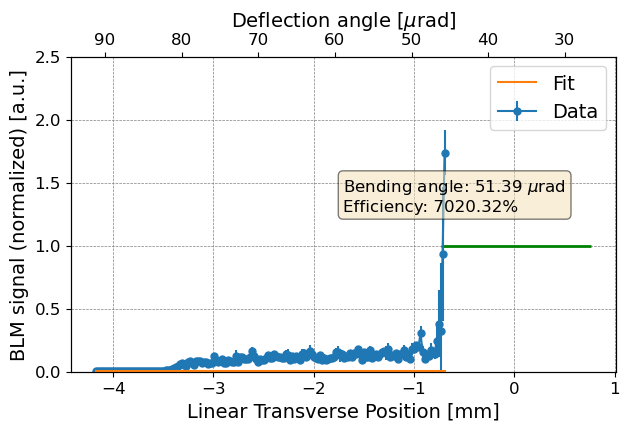

In [50]:
f2 = plt.figure(2)
maxfit = 6.677
# raw_input()

def erfunc(x,a,b,c,d):
	return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))
	
ax1 = f2.add_subplot(111)
# plt.title('BLM signal vs Local transverse position of absorber', fontsize=14, y=1.20)

actualpos_filt = []
signalblm_filt = []
errblm_filt = []
for i in range(len(actualpos)):
	if (actualpos[i]<maxfit):
		actualpos_filt.append(actualpos[i])
		signalblm_filt.append(signalblm_norm[i])
		errblm_filt.append(errblm_norm[i])

params, extras = opt.curve_fit(erfunc, actualpos_filt, signalblm_filt, p0=param0, sigma=errblm_filt)

print('Height: ', abs(params[1]), ' a.u.')
print('Mean: ', params[2], ' mm')
print('Sigma: ', abs(params[3]), ' mm')

signalblm_notnorm=[]
for i in signalblm_norm:
	signalblm_notnorm.append(i*normal)

with open(oScanNorm,'w') as oFile:
	oFile.write('# Pos SignalBLM SignalBLMNorm\n')
	writer = csv.writer(oFile,delimiter='\t')
	writer.writerows(zip(actualpos,signalblm_notnorm,signalblm_norm))


if config == 'B2V' and scan == '3':
	xenv = 1.163
else:
	xenv = abs(norm_l)
xdef = abs(params[2])
deltax = (xdef-xenv)*1.0e-3

theta_calc = (deltax-sigma1*np.sqrt(emittance*beta2)*(np.cos(deltaphi)-1))/(np.sqrt(beta2*beta1)*np.sin(deltaphi))
print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))


x1 = -xenv
y1 = 0
x2 = -xdef
y2 = theta_calc*1.0e6
m = (y2-y1)/(x2-x1)
q = y1-m*x1


actualpos_pos = [-i for i in actualpos]
actualpos_conv = [m*(-i)+q for i in actualpos_pos]


# ax1.plot(actualpos, abs(params[1])*norm.pdf(actualpos,params[2],abs(params[3])), label='Ch beam profile', color='green')
ax3 = ax1.twiny()
ax1.errorbar(actualpos_pos, signalblm_norm, yerr=errblm_norm, label='Data', marker='o', markersize=5)
ax1.plot(actualpos_pos, erfunc(actualpos, *params), label='Fit', zorder=10)
ax3.plot(actualpos_conv, signalblm_norm, alpha=0.0)
ticks = ax3.get_xticks()
ax3.set_xticklabels([int(abs(tick)) for tick in ticks])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel('Linear Transverse Position [mm]', fontsize=14)
ax1.set_ylabel('BLM signal (normalized) [a.u.]', fontsize=14)
# ax1.set_ylabel('Channeled beam profile [a.u.]', fontsize=12)
ax3.set_xlabel('Deflection angle [$\mu$rad]', fontsize=14)
ax1.hlines(y=1, xmin=-norm_l, xmax=-norm_l+meanlim, linewidth=2, color='green')
# ax1.get_yaxis().set_visible(False)
if config == 'B2V' and scan == '3':
	ax1.set_ylim(0,5)
else:
	ax1.set_ylim(0,2.5)
ax1.grid(color='gray', linestyle='--', linewidth=0.5)
# ax1.yaxis.grid(False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
lines1, labels1 = ax1.get_legend_handles_labels()
plt.legend(lines1, labels1, fontsize=14, loc=1)
ax1.grid(color='gray', linestyle='--', linewidth=0.5)
textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.5, 0.5, textstr, transform=ax1.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

f2.show()
f2.tight_layout(rect=[0, 0.03, 1, 0.95])
#f2.savefig(oBLMFit)

/tmp/cmaccani/ipykernel_54340/623642714.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f3.show()


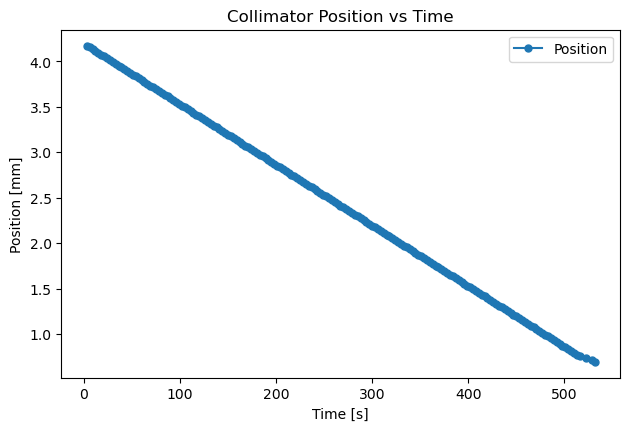

In [51]:
f3 = plt.figure(3)
plt.title('Collimator Position vs Time')
plt.plot(t, collpos, label='Position', marker='o', markersize=5)
plt.xlabel('Time [s]')
plt.ylabel('Position [mm]')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()

f3.show()
f3.tight_layout(rect=[0, 0.03, 1, 0.95])
#f0.savefig(oBeamInt)

In [53]:
angle = []
for i in range(len(actualpos)):
#	print (((actualpos_pos[i]-xenv)*1.0e-3)-sigma1*np.sqrt(emittance*beta2)*(np.cos(deltaphi)-1))/(np.sqrt(beta2*beta1)*np.sin(deltaphi))*1.0e6
	angle.append(-(((actualpos_pos[i]-xenv)*1.0e-3)-sigma1*np.sqrt(emittance*beta2)*(np.cos(deltaphi)-1))/(np.sqrt(beta2*beta1)*np.sin(deltaphi))*1.0e6)

angle_filt = []
signalblm_filt_2 = []
errblm_filt_2 = []
for i in range(len(angle)):
	if config == 'B2H':
		if (angle[i]<-30):
			angle_filt.append(angle[i])
			signalblm_filt_2.append(signalblm_norm[i])
			errblm_filt_2.append(errblm_norm[i])
	else:
		if (angle[i]<-20):
			angle_filt.append(angle[i])
			signalblm_filt_2.append(signalblm_norm[i])
			errblm_filt_2.append(errblm_norm[i])

param0_2 = param0

params_2, extras_2 = opt.curve_fit(erfunc, angle_filt, signalblm_filt_2, p0=param0_2, sigma=errblm_filt_2)
"""print('Height: ', abs(params_2[1]), ' a.u.')
print('Mean: ', params_2[2], ' urad')
print('Sigma: ', abs(params_2[3]), ' urad')"""

f4 = plt.figure(4)
ax4 = f4.add_subplot(111)
ax5 = ax4.twinx()
# ax5.get_yaxis().set_visible(False)
ax4.errorbar(angle, signalblm_norm, yerr=errblm_norm, label='Data', marker='o', markersize=5)
#ax5.plot(angle, abs(params_2[1])*norm.pdf(angle,params_2[2],abs(params_2[3])), label='Ch beam profile', color='green')
#ax4.plot(angle, erfunc(angle, *params_2), label='Fit', zorder=10)
ax4.set_xlabel('Deflection angle [$\mu$rad]', fontsize=14)
ax4.set_ylabel('BLM signal (normalized) [a.u.]', fontsize=14)
ax5.set_ylabel('Channeled beam profile [a.u.]', fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if config == 'B2V' and scan == '3':
	ax4.set_ylim(0,5)
	ax5.set_ylim(0,2.5)
else:
	ax4.set_ylim(0,2.5)
	ax5.set_ylim(0,0.4)
ax4.grid(color='gray', linestyle='--', linewidth=0.5)

f4.show()
f4.tight_layout(rect=[0, 0.03, 1, 0.95])
#f4.savefig('BLMSignalNormFit__'+config+'_'+scan+'FT_withChprofile.png')

ValueError: `ydata` must not be empty!